In [1]:
%load_ext nb_mypy
%nb_mypy Off
%matplotlib ipympl

Version 1.0.5


In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import time
from functools import partial
from ipywidgets import interact, IntSlider
from jax import Array, grad, jit, jvp, vmap
from more_itertools import take
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from nlsa.abstract_algebra2 import FromScalarField, ldivide_by, multiply_by
from nlsa.function_algebra2 import compose, compose2, BivariateFunctionSpace
from nlsa.kernels import bs_normalize, dm_normalize, dmsym_normalize, \
    make_exponential_rbf, make_integral_operator, make_tuning_objective, \
    make_bandwidth_function, make_scaled_sqdist, riemannian_vol
from nlsa.jax.dynamics import make_rotation_vector_field
from nlsa.jax.vector_algebra import MeasureFnAlgebra, ScalarField,\
    VectorAlgebra, counting_measure, veval_at, sqeuclidean, \
    make_vector_analysis_operator, make_fn_synthesis_operator
from nlsa.utils import swap_args
from numpy.typing import NDArray
from scipy.sparse.linalg import LinearOperator, eigs, eigsh
from typing import Callable, Literal, TypeVar

In [ ]:
IDX_CPU = None
IDX_GPU = None
XLA_MEM_FRACTION = '.9'
F64 = False
SAVE_FIGS = False

if IDX_CPU is None and XLA_MEM_FRACTION is not None:
    # This has to come first in order to take effect.
    os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = XLA_MEM_FRACTION

match IDX_CPU, IDX_GPU:
    case int(IDX_CPU), None:
        jax.config.update("jax_default_device", jax.devices("cpu")[IDX_CPU])
    case None, int(IDX_GPU):    
        jax.config.update("jax_default_device", jax.devices("gpu")[IDX_GPU])

if F64:
    jax.config.update("jax_enable_x64", True)
    r_dtype = jnp.float64
    c_dtype = jnp.complex128
else:
    r_dtype = jnp.float32
    c_dtype = jnp.complex64

In [3]:
jvmap = compose(jit, vmap)
vvmap = compose(vmap, vmap)
jvvmap = compose(jit, vvmap)

In [4]:
N = Literal[32]
M = Literal[8]

R = Array
Rm = Array
T2 = Array
T2n = Array
X = Array
Xn = Array
V = Array
Vm = Array
W = Array
K = jnp.float32

S = TypeVar('S')
T = TypeVar('T')
F = Callable[[S], T]

Alpha = Literal['0', '0.5', '1']

In [5]:
alphas = jnp.array([1., jnp.sqrt(30)])

def embed_r4(theta: T2) -> X:
    """Embed points in the 2-torus into R4."""
    return jnp.array([jnp.cos(theta[0]), jnp.sin(theta[0]),
                      jnp.cos(theta[1]), jnp.sin(theta[1])])

v = make_rotation_vector_field(alphas)

In [6]:
n_grd = 128
n = n_grd ** 2

thetas_grd = jnp.linspace(0., 2.*jnp.pi, n_grd, endpoint=False)
theta1s, theta2s = jnp.meshgrid(thetas_grd, thetas_grd)
thetas: T2n = jnp.concatenate((theta1s[:, :, jnp.newaxis],
                               theta2s[:, :, jnp.newaxis]), 
                              axis=2)
theta1s = theta1s / jnp.pi
theta2s = theta2s / jnp.pi
xs: Xn = thetas.reshape(n, 2)
#xs: Xn = embed_r4(thetas).reshape(n, 4)

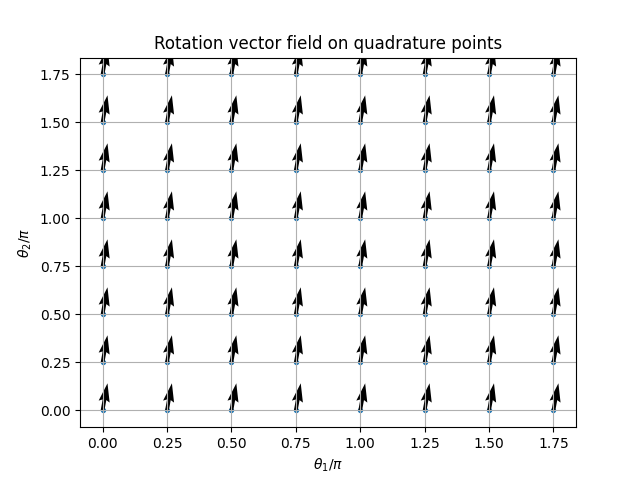

In [23]:
n_skip = 2

i_fig = 1
if plt.fignum_exists(i_fig):
    plt.close(i_fig)


def initfig_vec(i):
    fig, ax = plt.subplots(num=i_fig)
    return (fig, ax)


def plotfig_vec(figspecs):
    theta1s_plt = theta1s[::n_skip]
    theta2s_plt = theta2s[::n_skip]
    vs_plt = jvvmap(v)(thetas[::n_skip, ::n_skip, :])
    fig, ax = figspecs    
    ax.scatter(theta1s_plt, theta2s_plt, s=8)
    ax.quiver(theta1s_plt, theta2s_plt, vs_plt[:, :, 0], vs_plt[:, :, 1])
    ax.grid()
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title('Rotation vector field on quadrature points');


plotfig_vec(initfig_vec(i_fig))

In [7]:
scl = ScalarField(dtype=r_dtype)
inclusion_map: Callable[[F[X, R]], V] = vec.veval_at(xs)
ell2: MeasureFnAlgebra[X, N, K] = \
    MeasureFnAlgebra(dim=n,
                     dtype=r_dtype,
                     inclusion_map=inclusion_map,
                     measure=vec.counting_measure)
fun: BivariateFunctionSpace[X, X, K, K] = \
    BivariateFunctionSpace(codomain=FromScalarField(scl))
sqdist: Callable[[X, X], R] = compose2(vec.sqeuclidean, (embed_r4, embed_r4))

In [8]:
n_bandwidth: int = 128
log10_bandwidth_lims: tuple[float, float] = (-3., 3.)

start_time = time.perf_counter()
log10_bandwidths = jnp.linspace(log10_bandwidth_lims[0],
                                log10_bandwidth_lims[1], n_bandwidth)
shape_func = partial(knl.make_exponential_rbf, scl)


def k_func(epsilon: R) -> Callable[[X, X], R]:
    return  compose(shape_func(epsilon), sqdist)


k_tune = jit(knl.make_tuning_objective(ell2, k_func, grad))
est_dims = jnp.array([k_tune(epsilon) for epsilon in log10_bandwidths])
i_opt = jnp.argmax(est_dims)
bandwidth_opt = 10. ** log10_bandwidths[i_opt]
dim_opt = est_dims[i_opt]
end_time = time.perf_counter()
print(f"Kernel tuning took {end_time - start_time:.3e} s")
print(f"Optimal bandwidth index: {i_opt}")
print(f"Optimal bandwidth: {bandwidth_opt:.3e}")
print(f"Estimated dimension from optimal bandwidth: {dim_opt:.3e}")

Kernel tuning took 3.801e+00 s
Optimal bandwidth index: 64
Optimal bandwidth: 1.056e+00
Estimated dimension from optimal bandwidth: 2.434e+00


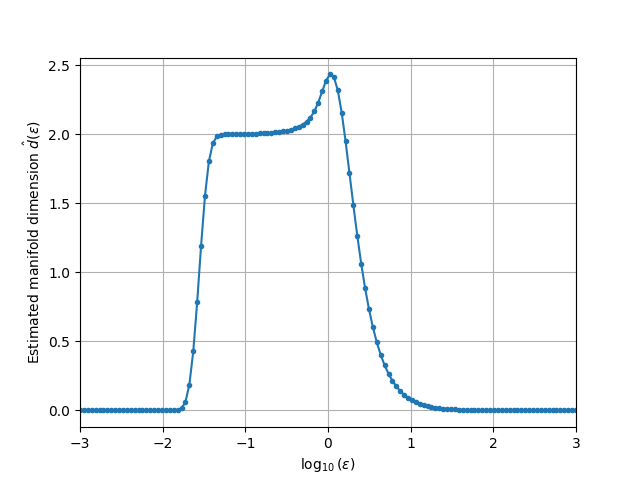

In [9]:
i_fig = 2

if plt.fignum_exists(i_fig):
    plt.close(i_fig)


def initfig_tuning(i):
    fig, ax = plt.subplots(num=i_fig)
    return (fig, ax)


def plotfig_tuning(figspecs):
    fig, ax = figspecs    
    ax.plot(log10_bandwidths, est_dims, '.-')
    ax.set_xlim(log10_bandwidth_lims)
    ax.grid()
    ax.set_xlabel('$\log_{10}(\epsilon)$')
    ax.set_ylabel('Estimated manifold dimension $\hat d(\epsilon)$');


plotfig_tuning(initfig_tuning(i_fig))

In [10]:
bandwidth_scl = 0.1
bandwidth = bandwidth_scl * bandwidth_opt
dim = k_tune(jnp.log10(bandwidth))
rbf: Callable[[X, X], R] = knl.make_exponential_rbf(scl, bandwidth)
k: Callable[[X, X], R] = compose(rbf, sqdist)
p: Callable[[X, X], R] = knl.dm_normalize(ell2, '1', k)
t_heat = bandwidth**2 / 4.0
fourpi = 4.0 * jnp.pi
vol = knl.riemannian_vol(ell2, p, dim, t_heat, fourpi)
bandwidth_func: Callable[[X], R] = knl.make_bandwidth_function(ell2, k, dim, vol)
scaled_sqdist: Callable[[X, X], R] = knl.make_scaled_sqdist(ell2, sqdist,  
                                                            bandwidth_func)
vol_true = (2. * jnp.pi) ** 2 
print(f"Estimated dimension: {dim:.3e}")
print(f"True volume: {vol_true:.3e}")
print(f"Estimated volume: {vol:.3e}")

Estimated dimension: 2.003e+00
True volume: 3.948e+01
Estimated volume: 3.924e+01


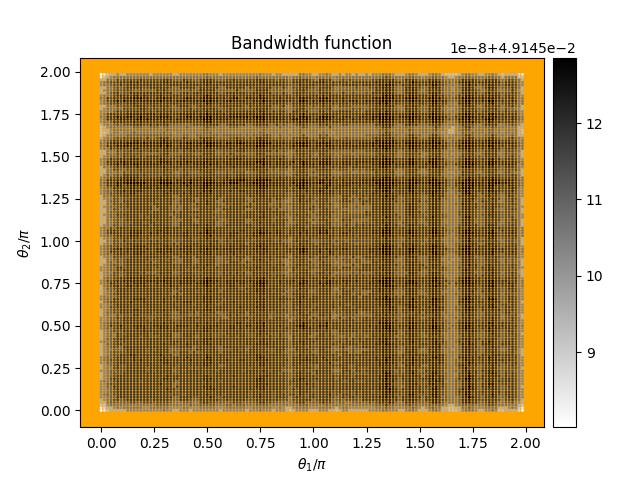

In [11]:
i_fig = 3

if plt.fignum_exists(i_fig):
    plt.close(i_fig)


def initfig_bandwidth(i):
    fig, ax = plt.subplots(num=i_fig)
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("right", size="4%", pad="2%")
    return (fig, ax, cax)


def plotfig_bandwidth(figspecs):
    fig, ax, cax = figspecs    
    plt.rcParams['grid.color'] = "yellow"    
    bw_vals = jvmap(bandwidth_func)(xs)
    sc = ax.scatter(theta1s, theta2s, c=bw_vals, s=1, 
                    vmin=jnp.min(bw_vals), vmax=jnp.max(bw_vals),
                    cmap="binary")
    fig.colorbar(sc, cax=cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title("Bandwidth function")
    ax.set_facecolor('orange')
    plt.rcdefaults();


plotfig_bandwidth(initfig_bandwidth(i_fig))

In [12]:
make_shape_func = partial(knl.make_exponential_rbf, scl)

def k_vb_func(epsilon: R) -> Callable[[X, X], R]:
    return compose(make_shape_func(epsilon), scaled_sqdist)

start_time = time.perf_counter()
k_vb_tune = jit(knl.make_tuning_objective(ell2, k_vb_func, grad))
est_vb_dims = jnp.array([k_vb_tune(epsilon)
                         for epsilon in log10_bandwidths])
i_opt_vb = jnp.argmax(est_vb_dims)
vb_bandwidth_opt = 10. ** log10_bandwidths[i_opt_vb]
end_time = time.perf_counter()
print(f"VB kernel tuning took {end_time - start_time:.3e} s")
print(f"Optimal bandwidth index: {i_opt_vb}")
print(f"Optimal bandwidth: {vb_bandwidth_opt:.3e}")
print(f"Estimated dimension from optimal bandwidth: {est_vb_dims[i_opt_vb]:.3e}")

VB kernel tuning took 2.626e+00 s
Optimal bandwidth index: 92
Optimal bandwidth: 2.221e+01
Estimated dimension from optimal bandwidth: 2.435e+00


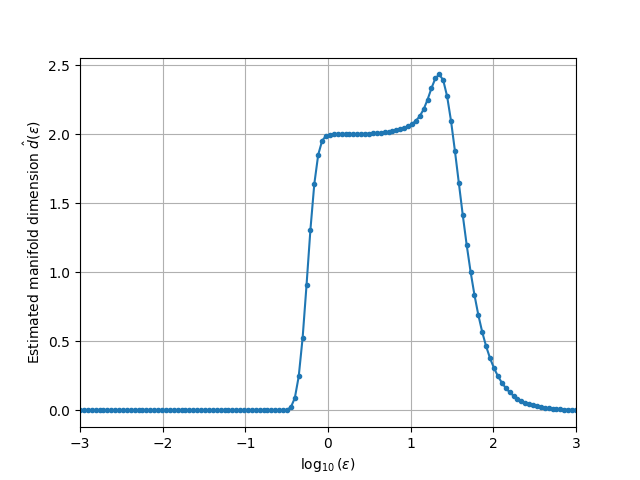

In [13]:
i_fig = 4
if plt.fignum_exists(i_fig):
    plt.close(i_fig)


def initfig_vbtuning(i):
    fig, ax = plt.subplots(num=i_fig)
    return (fig, ax)


def plotfig_vbtuning(figspecs):
    fig, ax = figspecs
    ax.plot(log10_bandwidths, est_vb_dims, '.-')
    ax.set_xlim(log10_bandwidth_lims)
    ax.grid()
    ax.set_xlabel('$\log_{10}(\epsilon)$')
    ax.set_ylabel('Estimated manifold dimension $\hat d(\epsilon)$');


plotfig_tuning(initfig_tuning(i_fig))

In [14]:
#vb_bandwidth_scl = 0.5
#vb_bandwidth = vb_bandwidth_scl * vb_bandwidth_opt
vb_bandwidth = 1.2
rbf_vb: Callable[[X, X], R] = knl.make_exponential_rbf(scl, vb_bandwidth)
k_vb: Callable[[X, X], R] = compose(rbf_vb, scaled_sqdist)
k_bs: Callable[[X, X], R] = bs_normalize(ell2, k_vb)
k_bs_transp = swap_args(k_bs)
k_bs_op: Callable[[V], F[X, R]] = make_integral_operator(ell2, k_bs)
k_bs_transp_op: Callable[[V], F[X, R]] = \
    make_integral_operator(ell2, k_bs_transp)
g_bs_op: F[V, V] = compose(veval_at(xs), k_bs_op)
g_bs_transp_op: F[V, V] = compose(veval_at(xs), k_bs_transp_op)
g_op: F[V, V] = compose(g_bs_op, g_bs_transp_op)
a = LinearOperator(shape=(n, n), dtype=dtype, matvec=jit(g_op))

#alpha: Alpha = '0.5'
#psym: Callable[[X, X], R] = dmsym_normalize(ell2, alpha, k_vb)
#psym_op: Callable[[V], F[X, R]] = make_integral_operator(ell2, psym)
#gsym_op: F[V, V] = compose(inclusion_map, psym_op)
#a = LinearOperator(shape=(n, n), dtype=dtype, matvec=jit(gsym_op))

In [15]:
m_eigs: int = 32
m: M = m_eigs

start_time = time.perf_counter()
unsorted_evals: Rm
unsorted_evecs: Vm
unsorted_evals, unsorted_evecs = eigsh(a, m_eigs, which='LA')
end_time = time.perf_counter()
print(f'Eigendecomposition took {end_time - start_time:.3e} s')

isort = jnp.argsort(unsorted_evals)
lambs = unsorted_evals[isort[::-1]]
etas = (1. - lambs) / vb_bandwidth**2 * 4.
us = unsorted_evecs[:, isort[::-1]]
phis = us * jnp.sqrt(float(n))
print('First 5 Laplacian eigenvalues:')
print(etas[0:5])

Eigendecomposition took 2.362e+01 s
First 5 Laplacian eigenvalues:
[-1.3245476e-06  4.8253271e-03  4.8268172e-03  4.8297974e-03
  4.8422148e-03]


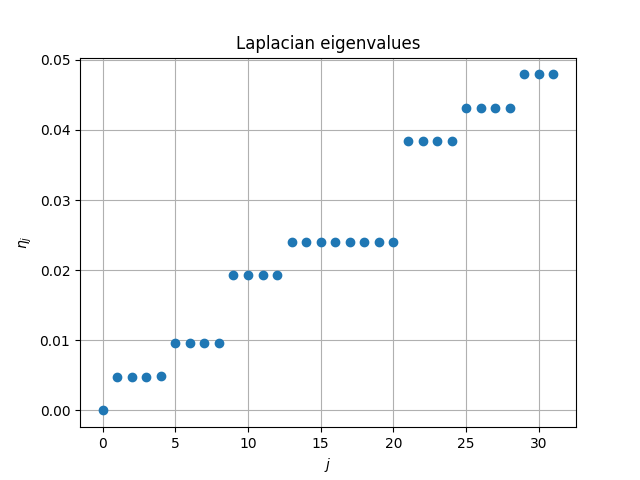

In [16]:
m_eig_plt = m_eigs
i_fig = 5

if plt.fignum_exists(i_fig):
    plt.close(i_fig)

def initfig_vbtuning(i):
    fig, ax = plt.subplots(num=i_fig)
    return (fig, ax)


def plotfig_vbtuning(figspecs):
    fig, ax = figspecs        
    fig5, ax5 = plt.subplots(num=i_fig)
    ax5.cla()
    ax5.plot(jnp.arange(0, m_eig_plt), etas[0 : m_eig_plt], 'o')
    ax5.grid()
    ax5.set_xlabel('$j$')
    ax5.set_ylabel('$\\eta_j$')
    ax5.set_title('Laplacian eigenvalues');


plotfig_tuning(initfig_tuning(i_fig))

interactive(children=(IntSlider(value=7, continuous_update=False, description='j', max=31), Output()), _dom_cl…

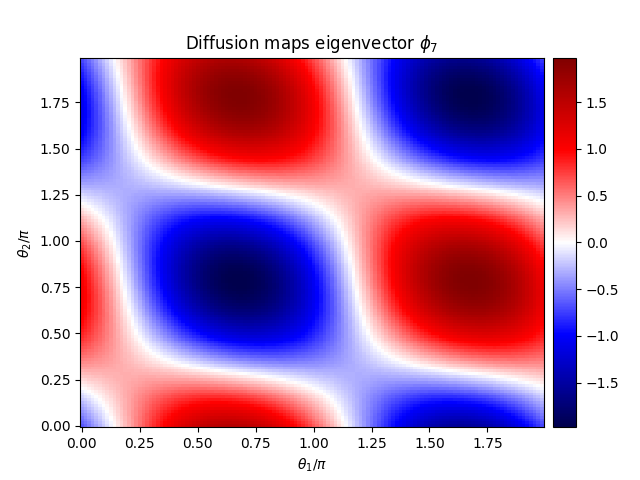

In [20]:
i_fig = 5

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig5, ax5 = plt.subplots(num=i_fig)
ax5_divider = make_axes_locatable(ax5)
cax5 = ax5_divider.append_axes("right", size="5%", pad="2%")
j_slider5 = IntSlider(value=7, min=0, max=m_eig_plt - 1, continuous_update=False)

@interact(j=j_slider5)
def plot_phi(j):
    v = jnp.max(jnp.abs(phis[:, j]))
    ax5.cla()
    cax5.cla()
    im = ax5.pcolormesh(theta1s, theta2s, phis[:, j].reshape(n_grd, n_grd),
                        vmin=-v, vmax=v, cmap="seismic")
    cb = fig5.colorbar(im, cax=cax5)
    ax5.set_xlabel('$\\theta_1/\\pi$')
    ax5.set_ylabel('$\\theta_2/\\pi$')
    ax5.set_title(f'Diffusion maps eigenvector $\\phi_{{{j}}}$') 

In [21]:
@swap_args
def v_grad_k_bs(x: X, y: X) -> R:
    _, vgp = jvp(partial(k_bs_transp, x), (y,), (v(y),))
    return vgp

v_grad_k_op = compose(make_integral_operator(ell2, v_grad_k_bs),
                      g_bs_transp_op)
v_grad_g_op = compose(inclusion_map, v_grad_k_op)
v_reg_op = compose(g_op, v_grad_g_op)
a2 = LinearOperator(shape=(n, n), dtype=dtype, matvec=jit(v_reg_op))

In [22]:
m_eigs_v: int = 1024 #400
m_v: M = m_eigs_v

start_time = time.perf_counter()
unsorted_omegas: Rm
unsorted_zetas: Vm
unsorted_omegas, unsorted_zetas = eigs(a2, m_eigs_v, which='LI')
#isort_omegas = jnp.argsort(unsorted_omegas)
#omegas = unsorted_omegas[isort_omegas[::-1]]
#zetas = unsorted_zetas[:, isort_omegas[::-1]]
omegas = unsorted_omegas[0 : m_v].imag
zetas = unsorted_zetas[:, 0 : m_v] * jnp.sqrt(float(n))
end_time = time.perf_counter()
print(f'Generator eigendecomposition took {end_time - start_time:.3e} s')
print('First 5 eigenfrequencies:')
print(unsorted_omegas[0:5])

Generator eigendecomposition took 1.602e+02 s
First 5 eigenfrequencies:
[-5.8207661e-11+40.45752j  -5.8207661e-11-40.45752j
  1.9222498e-06+40.347454j  1.9222498e-06-40.347454j
 -1.8477440e-06+40.285965j]


interactive(children=(IntSlider(value=1000, continuous_update=False, description='j', max=1023), Output()), _d…

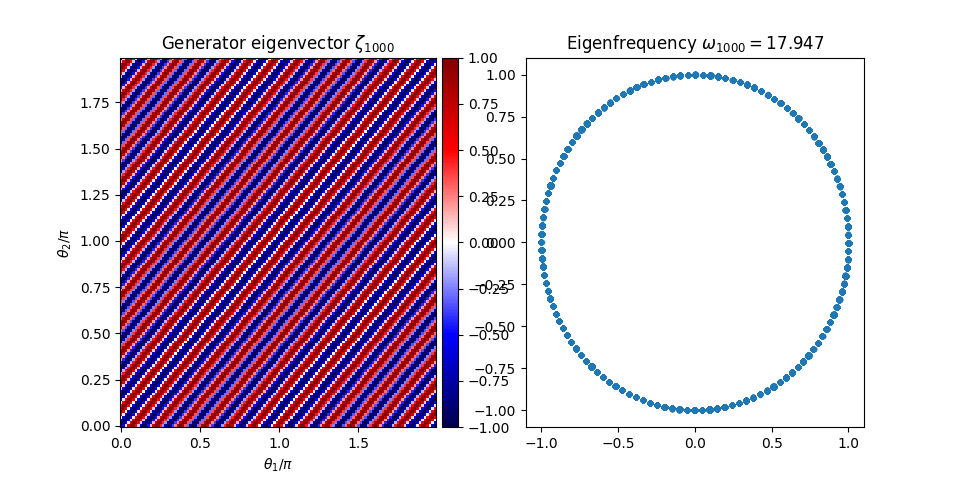

In [28]:
i_fig = 6

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig6 = plt.figure(num=i_fig, figsize=plt.figaspect(.5))
ax6 = fig6.add_subplot(1, 2, 1)
ax6_2 = fig6.add_subplot(1, 2, 2)
ax6_divider = make_axes_locatable(ax6)
cax6 = ax6_divider.append_axes("right", size="5%", pad="2%")
j_slider6 = IntSlider(value=1000, min=0, max=m_eigs_v - 1, continuous_update=False)

@interact(j=j_slider6)
def plot_zeta(j):
    v = jnp.max(jnp.abs(zetas[:, j].real))
    ax6.cla()
    cax6.cla()
    ax6_2.cla()
    im = ax6.pcolormesh(theta1s, theta2s, zetas[:, j].reshape(n_grd, n_grd).real,
                        vmin=-v, vmax=v, cmap="seismic")
    cb = fig6.colorbar(im, cax=cax6)
    ax6.set_xlabel('$\\theta_1/\\pi$')
    ax6.set_ylabel('$\\theta_2/\\pi$')
    ax6.set_title(f'Generator eigenvector $\\zeta_{{{j}}}$')
    ax6_2.plot(zetas[:, j].real, zetas[:, j].imag, '.')
    ax6_2.set_title(f'Eigenfrequency $\\omega_{{{j}}}={omegas[j]:.3f}$') 